In [1]:
%load_ext autoreload
%autoreload 2
import numpy as np
import sys
sys.path.append('../')
from model.erroneousChoice import  erroneousChoice
from kernel import jaxrbf
from utility import  paramz
import matplotlib.pyplot as plt  

# Choice functions

We seek to model Alice's (our subject) preferences among various types of cupcake. We assume that the differences between these cupcake types is determined by their recipe.  In the context of choice modelling,  our primary goal is on observing Alice's choices among the various cupcake options, without delving into the specifics of how her preferences are determined. To be more specific, we present Alice with a set of different cupcakes, each one prepared with a different recipe that defines its characteristics, and ask her to pick the ones that appeal to her the most. 

## Choosing Cupcakes

We consider a scenario, where Alice chooses her favourite cupcakes from given choice-sets (where the cupcakes differ for the amount of butter $x$ (the attribute of the object) expressed in some normalised scale). We assume Alice's choices are determined by the two latent  utilities shown in the below figure.

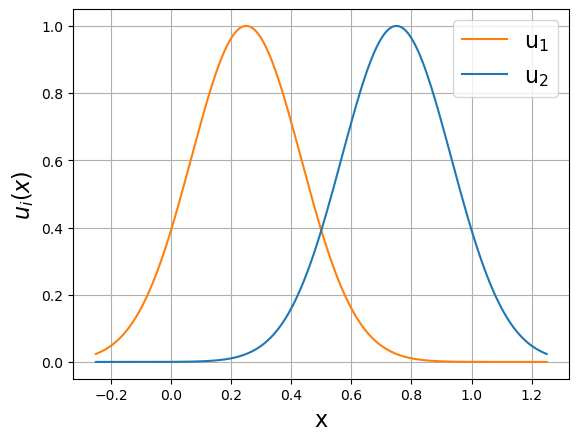

In [2]:
np.random.seed(1)
bounds=[[-0.25,1.25]]
# define true latent utilities
def fun(x,sigma=0):
    u1 = np.exp(-(x-0.25)**2*15)+np.random.randn(len(x),1)*sigma 
    u2 = np.exp(-(x-0.75)**2*15)+np.random.randn(len(x),1)*sigma 
    return np.hstack([u1,u2])
Xpred=np.linspace(bounds[0][0],bounds[0][1],200)[:,None]
#plot
output = fun(Xpred,0.0)
plt.plot(Xpred[:,0],output[:,0],color='C1',label="u$_1$")
plt.plot(Xpred[:,0],output[:,1],color='C0',label="u$_2$")
plt.xlabel("x",fontsize=16)
plt.ylabel("$u_i(x)$",fontsize=16);
plt.grid()
plt.legend(fontsize=16)
#plt.savefig("figures/ChoiceCupcake.pdf")

# Learning from choice data

We now generate choice data assuming the bi-dimensional utility function ${\bf u}(x)=[u_1(x),u_2(x)]$. We consider two situations:

1. Alice's choices are determined by ${\bf u}$ via Pareto dominance (__rational chocies__). For instance, consider the set of options $A_k=\{x_1,x_2,x_3\}$, assume that ${\bf u}(x_1)=[1,-0.6]$, ${\bf u}(x_2)=[0.5,-0.5]$, ${\bf u}(x_3)=[-0.6,1]$, then Alice will choose  $C(A_k)=\{x_1,x_2,x_3\}$. In fact, one can notice that  $[1,-0.6]$, $[0.5,-0.5]$ and $[-0.6,1]$ are undominated in Pareto sense. 
2. Alice chooses objects by looking at the best utility (__pseudo-rational chocies__). In the previous example, when we consider the first utility,  the best object is $x_1$, becuase $1>0.5>-0.6$.  When we consider the second utility,  the best object is $x_2$, because $1>-0.5>-0.6$. Therefore, Alice chooses $C(A_k)=\{x_1,x_3\}$ and rejects $R(A_k)=A_k \backslash C(A_k)=\{x_2\}$.

 We sample $50$ inputs $x_i$ at random in $[-0.25,1.25]$ and, using either rationality or pseudo-rationality, we generate a dataset 
of $m=200$ random subsets $\{A_k\}_{k=1}^m$ of the 30 points each one of size $|A_k|=3$  and computed the corresponding choice pairs $(C(A_k),A_k)$ based on  ${\bf u}$ defined by `fun`.

Note that, here we use botorch (and torch) only to build the dataset (in particular we use the function `is_non_dominated`).

In [34]:
#choose type of rationality
typeR_data ='pseudo'#'rational'|'pseudo'
typeR_model='pseudo'#'rational'|'pseudo'

In [35]:
import torch
from botorch.utils.multi_objective import is_non_dominated

def is_pareto(X):
    return is_non_dominated(torch.from_numpy(X),deduplicate=False)

#generate CA RA sets
def make_CA_RA(x, y, rows=[],typeR='rational'):
    if len(rows)==0:
        rows=np.arange(x.shape[0])
    if typeR=='rational':
        acc = rows[is_pareto(y)]
        rej = rows[~ is_pareto(y)]
    elif typeR=='pseudo':
        indy = np.unique(np.argmax(y,axis=0))
        acc = rows[indy]
        rej = rows[np.setdiff1d(np.arange(x.shape[0]),indy)]
    return acc, rej

def make_observations(X, fun, nA, dimA,typeR='rational'):
    CA=[]
    RA=[]   
    ix = 0
    for i in range(nA):
        rows = np.random.permutation(np.arange(X.shape[0]))[0:dimA]
        x=X[rows,:]
        y=fun(x)
        acc,rej=make_CA_RA(x, y, rows,typeR=typeR)
        if len(acc)>0:
            CA.append(acc)
        else:
            CA.append([])
        if len(acc)<dimA:
            RA.append(rej)
        else:
            RA.append([])
        ix = ix+1
    return CA, RA


#generate data
np.random.seed(123)

# we randomly generate objects
n = 60 # number of objects
X = (np.vstack(bounds)[:,0]+np.random.rand(n,1)*(np.vstack(bounds)[:,1]-np.vstack(bounds)[:,0]))

# we randomly generate choice data
nA = 200 # number of choice sets
dimA = 3 # dimension of each choice set
CA, RA = make_observations(X, fun, nA, dimA,typeR=typeR_data)
print(CA[0:4],"\n",RA[0:4])

[array([36, 59]), array([31, 56]), array([53, 22]), array([25, 15])] 
 [array([21]), array([6]), array([13]), array([45])]


## Gaussian Process

The following code allows us to learn a choice function from choice-data. We have to select the latent dimension `latent_dim`, which represents the number of __latent utility functions__. Similarly to GP processes for multiclass classification, we model each  latent utility function in the vector ${\bf u}({\bf x})=[u_1({\bf x}),\dots,u_{d}({\bf x})]^\top$ as an independent GP:

$$
 u_i({\bf x}) \sim \text{GP}_i(0,k_i({\bf x},{\bf x}')), ~~~~i=1,2,\dots,d.
$$

 Each GP is fully specified by its kernel function $k_i(\cdot,\cdot)$, which defines the covariance of the latent function between any two points. The model parameters are the kernel parameters (lengthscales) in $k_i(\cdot,\cdot)$, and the variance. These parameters must be initiliased and then they are optimised using variational inference.

 We assume we know the number of latent utilities and select `latent_dim=2`. We can learn a model assuming `rationality` or `pseudo-rationality`. Note that, the pseudo-rationality implies rationality.

In [36]:
#choice data
data={'X': X,#objects
      'CA': CA,#choiced objects
      'RA': RA,#rejected objects
      'dimA':dimA# dimension of the choice set
          }

# number of latent utilities
latent_dim=2

# define kernel 
Kernel = jaxrbf.RBF

#hyperparameters of the kernel, we have a kernel for each latent utility
params = {'lengthscale_0': {'value':0.77*np.ones(data["X"].shape[1],float), 
                            'range':np.vstack([[0.1, 3.0]]*data["X"].shape[1]),
                            'transform': paramz.logexp()},
           'variance_0': {'value':np.array([1.0]), 
                            'range':np.vstack([[0.1, 100.0]]),
                            'transform': paramz.logexp()},
          
          'lengthscale_1': {'value':0.77*np.ones(data["X"].shape[1],float), 
                            'range':np.vstack([[0.1, 3.0]]*data["X"].shape[1]),
                            'transform': paramz.logexp()},
           'variance_1': {'value':np.array([1.0]), 
                            'range':np.vstack([[0.1, 100.0]]),
                            'transform': paramz.logexp()}
              }



# define choice model 
model = erroneousChoice(data,Kernel,params,latent_dim,typeR=typeR_model,jitter=1e-6)
#Note that typeR="rational" means we assume choices are based on Pareto dominance.

#Compute variational inference and estimate hyperparameters
model.optimize_hyperparams(niterations=3000,kernel_hypers_fixed=False)
print(model.params)

188.6353851779778
1458.1098412059105
188.63538499637033
188.63538505299852
188.63538506543176


 lower bound 168.20586391051037: 100%|██████| 3000/3000 [01:04<00:00, 46.84it/s]


{'lengthscale_0': {'value': array([0.57164056]), 'range': array([[0.1, 3. ]]), 'transform': <utility.paramz.logexp object at 0x7fa5d31ada50>}, 'variance_0': {'value': array([6.00329993]), 'range': array([[1.e-01, 1.e+02]]), 'transform': <utility.paramz.logexp object at 0x7fa5d33593d0>}, 'lengthscale_1': {'value': array([0.51648908]), 'range': array([[0.1, 3. ]]), 'transform': <utility.paramz.logexp object at 0x7fa5d335acd0>}, 'variance_1': {'value': array([5.4674198]), 'range': array([[1.e-01, 1.e+02]]), 'transform': <utility.paramz.logexp object at 0x7fa5d3358c50>}}


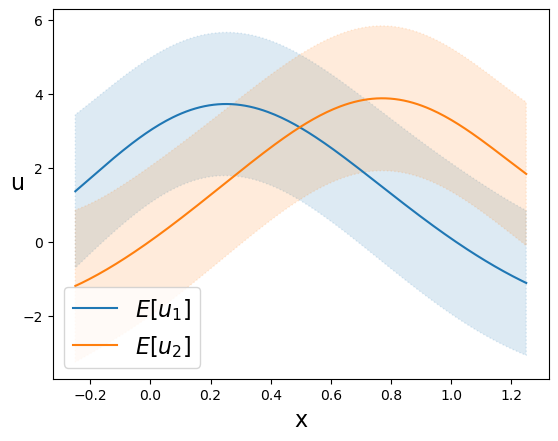

In [37]:
predictions = model.predict_VI(Xpred)

mean=predictions[0]
Sigma=predictions[1]

mean1=mean[0:Xpred.shape[0]]#mean of the first utility
mean2=mean[Xpred.shape[0]:]#mean of the second utility
d=np.sqrt(np.diag(Sigma[0:Xpred.shape[0],0:Xpred.shape[0]]))[:,None] #variances of the first utility
cred_int1=mean1+2*np.hstack([-d,d])
d=np.sqrt(np.diag(Sigma[Xpred.shape[0]:,Xpred.shape[0]:]))[:,None] #variances of the second utility
cred_int2=mean2+2*np.hstack([-d,d])
#plotting
plt.plot(Xpred[:,0],mean1,color='C0',label="$E[u_1]$")
plt.plot(Xpred[:,0],mean2,color='C1',label="$E[u_2]$")
plt.fill_between(Xpred[:,0],cred_int1[:,0],cred_int1[:,1],
                 color='C0', linestyle=':',alpha=0.15)

plt.fill_between(Xpred[:,0],cred_int2[:,0],cred_int2[:,1],color='C1', linestyle=':',alpha=0.15)

plt.xlabel("x", fontsize=16)
plt.ylabel("u", fontsize=16, rotation=0)
plt.legend(fontsize=16,loc='lower left')
plt.savefig("figures/EstimatedCupcakes_pseudo_pseudo.pdf")

We can also plot the sampled utilities.

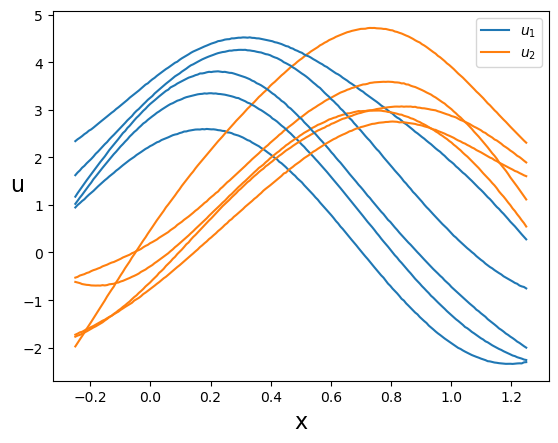

In [39]:
from scipy.stats import multivariate_normal
np.random.seed(1)
mean = predictions[0]
Sigma = predictions[1]
#first utility
ns = 5
samples = multivariate_normal(mean[:,0],Sigma+1e-5*np.eye(Sigma.shape[0])).rvs(ns)
u1 = samples[0][0:Xpred.shape[0]] #sample of first utility
u2 = samples[0][Xpred.shape[0]:] #sample of second utility
plt.plot(Xpred[:,0],u1,color='C0',label="$u_1$")
plt.plot(Xpred[:,0],u2,color='C1',label="$u_2$")
for i in range(1,ns):
    u1 = samples[i][0:Xpred.shape[0]] #sample of first utility
    u2 = samples[i][Xpred.shape[0]:] #sample of second utility
    plt.plot(Xpred[:,0],u1,color='C0')
    plt.plot(Xpred[:,0],u2,color='C1')
plt.legend()
plt.xlabel("x", fontsize=16)
plt.ylabel("u", fontsize=16, rotation=0)
plt.savefig("figures/Estimatedcupcakesamples_pseudo_pseudo.pdf")